In [1]:
#Misc
import signal
import sys
sys.path.append("../../../")
sys.path.append("../")
from loss_functions_lib import *
from utils import build_sequential_data, data, targets
from NN import MNIST_feature_map
#Torch
import torch
from torch.utils.data import DataLoader, TensorDataset

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

#Numpy-Matplotlib-tqdm-sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
#DynamicalSystems
from kooplearn.kernels import Linear, RBF, TorchScalarProduct
from kooplearn.estimators import KernelRidge, ReducedRank

In [2]:
d = 28 #Image Size in px
#Hyperparameter initialization
tikhonov_reg_linear = 48.3293 #CV
gamma_linear = d**-2 #CV
tikhonov_reg_RBF = 0.00785 #CV
RBF_length_scale = 28*28

In [3]:
#Datasets initialization
num_classes = 10
num_train_samples = 1000
batch_size = 100

sorting_permutation = build_sequential_data(num_classes=num_classes)

dataset = data[sorting_permutation].reshape(-1,d**2)/256 - 0.5 #Standardizing dataset
torch_dataset = torch.from_numpy(dataset)

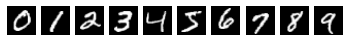

In [4]:
n_examples = num_classes
fig, axes = plt.subplots(1, ncols=n_examples)
for idx in range(n_examples):
    axes[idx].imshow(dataset[idx].reshape(d,d), cmap='gray') 
    axes[idx].axis('off')


In [22]:
#Training init
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_torch = torch_dataset[:-1].reshape((-1,1, d, d)) #Reshaping for conv2d
Y_torch = torch_dataset[1:]

tensor_dataset = TensorDataset(X_torch[:num_train_samples], Y_torch[:num_train_samples])
loader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

#### Train CNN-Kernel

In [23]:
def classifier_train(num_epochs, cnn, loader, lr = 1e-4):
    optimizer = torch.optim.Adam(cnn.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, cooldown=3)  
    cnn.train()
    # Train the model
    for epoch in range(num_epochs):
        for i, (X, Y) in enumerate(loader):
            if i == 0:     
                #Holomorphic score should be maximized
                loss = -holomorphic_score(cnn, X.to(device), Y.to(device), holomorphic_transformation=torch.abs)
                
                # clear gradients for this training step   
                optimizer.zero_grad()           
                
                # backpropagation, compute gradients 
                loss.backward()    
                # apply gradients             
                optimizer.step()
                #scheduler
                scheduler.step(loss)
        writer.add_scalar("Loss/epochs", loss, epoch)
        #print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))
    writer.flush()

In [24]:
net = MNIST_feature_map(out_features=10, momentum=0.99).to(device)
classifier_train(200, net, loader, lr=1e-4)
net.eval()

MNIST_feature_map(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin): Linear(in_features=1568, out_features=10, bias=True)
  (batch_whitening): ZCAWhitening()
)

### Learning with Linear, RBF and DeepKernel

In [25]:
def feature_map(x):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x).to(torch.float)
    if not x.device == device:
        x = x.to(device)
    return net(x)

cnn_kernel = TorchScalarProduct(feature_map)
kernels = [Linear(gamma=gamma_linear), RBF(length_scale = 28*28), cnn_kernel]
tikhonov_regs = [tikhonov_reg_linear, tikhonov_reg_RBF, 1e-6]
trained_estimators = []
X = dataset[:-1]
Y = dataset[1:]

X_train = X[:num_train_samples]
Y_train = Y[:num_train_samples] 

for k_idx, kernel in enumerate(kernels):
    K = KernelRidge(kernel=kernel, tikhonov_reg=tikhonov_regs[k_idx])
    K.fit(X_train, Y_train)
    trained_estimators.append(K)

### Debugging

In [26]:
with torch.no_grad():
    C_X = covariance_matrix(net, X_torch[:num_train_samples].to(device), X_torch[:num_train_samples].to(device)).cpu().numpy()
    C_Y = covariance_matrix(net, Y_torch[:num_train_samples].to(device), Y_torch[:num_train_samples].to(device)).cpu().numpy()
    T = covariance_matrix(net, X_torch[:num_train_samples].to(device), Y_torch[:num_train_samples].to(device)).cpu().numpy()

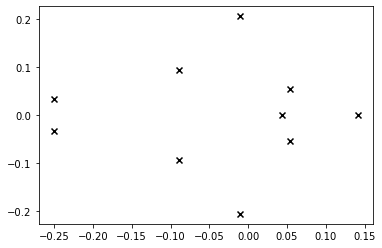

In [27]:
w_T = np.linalg.eigvals(T)
plt.scatter(w_T.real, w_T.imag, color='k', marker = 'x')

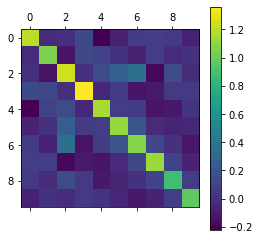

In [29]:
plt.matshow(C_X)
plt.colorbar()

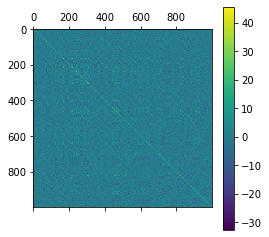

In [30]:
plt.matshow(trained_estimators[-1].K_X_)
plt.colorbar()

### Testing

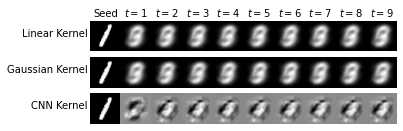

In [31]:
seed = 1 # int between 0 and 9
X_0 = X[num_train_samples + num_train_samples%num_classes + seed][None, :].reshape(28,28)
_img_data = []
for row in range(len(trained_estimators)):
    estimator = trained_estimators[row]
    _kernel_name = estimator.kernel.__class__.__name__
    _imgs = [X_0]
    for col in range(num_classes):
        X_val = _imgs[-1].reshape(1, 28*28)
        Y_val = estimator.predict(X_val)
        Y_val = np.squeeze(Y_val).reshape(28,28)
        _imgs.append(Y_val)
    _img_data.append(_imgs)
test_data = np.array(_img_data)
num_classes = test_data.shape[1] - 1
labels = ['Linear Kernel', 'Gaussian Kernel', 'CNN Kernel']

fig_width = 5.5 #Inches
fig_height = 2 #Inches
fig, axes = plt.subplots(nrows = test_data.shape[0], ncols=num_classes, figsize=(fig_width, fig_height))
plt.subplots_adjust(wspace=0, hspace=0)
for row in range(test_data.shape[0]):
    for col in range(num_classes):
        ax = axes[row, col]
        ax.axis('off')
        Y_val = test_data[row, col]
        ax.imshow(Y_val, cmap="gray")
        if col == 0:
            ax.text(-2, 14, labels[row], ha='right')
        if row == 0:
            if col == 0:
                ax.text(14, -4, "Seed", ha='center')
            elif 0 < col < num_classes:
                ax.text(14, -4, r"$t = {}$".format(col), ha='center')
#plt.savefig(f"figs/{seed}_prediction.pdf", bbox_inches='tight')